In [1]:
# Cell 1: imports, global config, HFF_OPTIONS, helper

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# ------------------------------------------------
# Data paths and HFF model options (your exact dict)
# ------------------------------------------------
BASE_PATH = "/content/drive/MyDrive/grtt/grtt_source_data/"

HFF_OPTIONS = {
    # ABELL 2744  (z = 0.308)
     1: dict(TAG="ABELL2744_CATS",   z=0.308,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell2744_cats_v4.1_kappa.fits"),
     2: dict(TAG="ABELL2744_GLAFIC", z=0.308,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell2744_glafic_v4_kappa.fits"),
     3: dict(TAG="ABELL2744_SHARON", z=0.308,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell2744_sharon_v4_kappa.fits"),

    # MACS 0416  (z = 0.396)
     4: dict(TAG="MACS0416_CATS",    z=0.396,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0416_cats_v4.1_kappa.fits"),
     5: dict(TAG="MACS0416_SHARON",  z=0.396,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0416_sharon_v4_kappa.fits"),
     6: dict(TAG="MACS0416_GLAFIC",  z=0.396,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0416_glafic_v4_kappa.fits"),

    # MACS 0717  (z = 0.546)
     7: dict(TAG="MACS0717_CATS",    z=0.546,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0717_cats_v4.1_kappa.fits"),
     8: dict(TAG="MACS0717_GLAFIC",  z=0.546,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0717_glafic_v3_kappa.fits"),
     9: dict(TAG="MACS0717_SHARON",  z=0.546,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs0717_sharon_v4_kappa.fits"),

    # MACS 1149  (z = 0.544)
    10: dict(TAG="MACS1149_CATS",    z=0.544,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs1149_cats_v4.1_kappa.fits"),
    11: dict(TAG="MACS1149_SHARON",  z=0.544,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs1149_sharon_v4_kappa.fits"),
    12: dict(TAG="MACS1149_GLAFIC",  z=0.544,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_macs1149_glafic_v3_kappa.fits"),

    # ABELLS 1063  (z = 0.348)
    13: dict(TAG="ABELLS1063_CATS",   z=0.348,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits"),
    14: dict(TAG="ABELLS1063_GLAFIC", z=0.348,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abells1063_glafic_v4_kappa.fits"),
    15: dict(TAG="ABELLS1063_SHARON", z=0.348,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abells1063_sharon_v4_kappa.fits"),

    # ABELL 370  (z = 0.375)
    16: dict(TAG="ABELL370_CATS",    z=0.375,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell370_cats_v4_kappa.fits"),
    17: dict(TAG="ABELL370_GLAFIC",  z=0.375,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell370_glafic_v4_kappa.fits"),
    18: dict(TAG="ABELL370_SHARON",  z=0.375,
             kappa=f"{BASE_PATH}stronglensing/hlsp_frontier_model_abell370_sharon_v4_kappa.fits"),
}

# ------------------------------------------------
# Global angular-binning config (EXACTLY as in your notebook)
# ------------------------------------------------
ANG_R_INNER = 6.0    # arcsec (matches old 20 pix for CATS)
ANG_R_OUTER = 150.0  # arcsec (matches old 500 pix for CATS)
N_BINS      = 40
BIN_SPACING = "linear"

SHOULDER_RMIN = 20.0  # arcsec (for shoulder search)
SHOULDER_RMAX = 80.0  # arcsec

# Masks / valid fraction (copied from MACS0416 config)
MASK_ZERO = True
MASK_NAN  = True
MIN_VALID_FRACTION = 0.8

# ------------------------------------------------
# Helper: pixel scale from header
# ------------------------------------------------
def pixel_scale_arcsec(header):
    """Return |CDELT1| or |CD1_1| in arcsec/pixel (as in the original angular-binning cell)."""
    if "CDELT1" in header:
        val = header["CDELT1"]
    elif "CD1_1" in header:
        val = header["CD1_1"]
    else:
        raise RuntimeError("No CDELT1/CD1_1 in header.")
    return abs(val) * 3600.0

# ------------------------------------------------
# Core pipeline: profile_with_angular_bins
# (verbatim science from your Cell 19)
# ------------------------------------------------
def profile_with_angular_bins(kappa_path, ra_str, dec_str, team_label):
    """Compute κ(R), RAW curvature and shoulder for one map using angular bins."""
    # load map
    hdul = fits.open(kappa_path)
    data = hdul[0].data
    hdr  = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pixscale = pixel_scale_arcsec(hdr)

    # centre in pixels
    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    cx, cy = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    cx, cy = float(cx), float(cy)

    ny, nx = data.shape
    yy, xx = np.indices(data.shape)
    r_pix = np.sqrt((xx - cx)**2 + (yy - cy)**2)

    # masks
    valid = np.ones_like(data, dtype=bool)
    if MASK_NAN:
        valid &= ~np.isnan(data)
    if MASK_ZERO:
        valid &= (data != 0.0)

    # angular bin edges
    if BIN_SPACING == "linear":
        edges_arc = np.linspace(ANG_R_INNER, ANG_R_OUTER, N_BINS + 1)
    else:
        edges_arc = np.logspace(np.log10(ANG_R_INNER), np.log10(ANG_R_OUTER), N_BINS + 1)

    # convert to pixels for this map
    edges_pix = edges_arc / pixscale
    mids_arc  = 0.5 * (edges_arc[:-1] + edges_arc[1:])

    rows = []
    for (rmin_pix, rmax_pix, rmid_arc) in zip(edges_pix[:-1], edges_pix[1:], mids_arc):
        ann = (r_pix >= rmin_pix) & (r_pix < rmax_pix)
        tot = ann.sum()
        if tot == 0:
            rows.append(dict(R_arcsec=rmid_arc,
                             kappa_mean=np.nan,
                             valid_fraction=0.0,
                             use_bin=False))
            continue
        good = ann & valid
        N_valid = good.sum()
        if N_valid == 0:
            rows.append(dict(R_arcsec=rmid_arc,
                             kappa_mean=np.nan,
                             valid_fraction=0.0,
                             use_bin=False))
            continue
        vals = data[good]
        kmean = float(vals.mean())
        vfrac = N_valid / tot
        rows.append(dict(
            R_arcsec=rmid_arc,
            kappa_mean=kmean,
            valid_fraction=vfrac,
            use_bin=(vfrac >= MIN_VALID_FRACTION),
        ))

    df = pd.DataFrame(rows)
    usable = df["use_bin"]
    R_arc = df.loc[usable, "R_arcsec"].values
    kappa_mean = df.loc[usable, "kappa_mean"].values

    # RAW curvature
    dk  = np.gradient(kappa_mean, R_arc)
    d2k = np.gradient(dk, R_arc)

    # shoulder: RAW curvature minimum in [SHOULDER_RMIN, SHOULDER_RMAX]
    mask_win = (R_arc >= SHOULDER_RMIN) & (R_arc <= SHOULDER_RMAX)
    Rw = R_arc[mask_win]
    cw = d2k[mask_win]
    if len(Rw) >= 3:
        idx = np.argmin(cw)
        R_sh = float(Rw[idx])
    else:
        R_sh = np.nan

    return dict(
        team=team_label,
        R_arcsec=R_arc,
        kappa_mean=kappa_mean,
        d2k=d2k,
        R_sh=R_sh,
        pixscale=pixscale,
    )

# global accumulator for final table
ALL_RESULTS = []


ABELL 2744 shoulder radii (angular-binned, RAW curvature, 20–80"):
  ABELL2744_CATS:   R_sh ≈ 43.800"
  ABELL2744_GLAFIC: R_sh ≈ 65.400"
  ABELL2744_SHARON: R_sh ≈ 65.400"


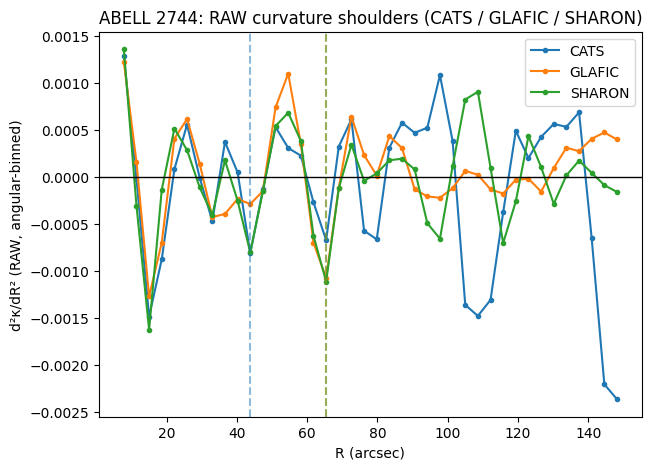

cluster              team  R_sh_arcsec
0  ABELL2744    ABELL2744_CATS         43.8
1  ABELL2744  ABELL2744_GLAFIC         65.4
2  ABELL2744  ABELL2744_SHARON         65.4

In [2]:
# Cell 2: ABELL 2744 — CATS / GLAFIC / SHARON

CENTER_RA_2744  = "00:14:20.312"
CENTER_DEC_2744 = "-30:23:18.10"

abell2744_cats = profile_with_angular_bins(
    HFF_OPTIONS[1]["kappa"], CENTER_RA_2744, CENTER_DEC_2744, "ABELL2744_CATS"
)
abell2744_glaf = profile_with_angular_bins(
    HFF_OPTIONS[2]["kappa"], CENTER_RA_2744, CENTER_DEC_2744, "ABELL2744_GLAFIC"
)
abell2744_shar = profile_with_angular_bins(
    HFF_OPTIONS[3]["kappa"], CENTER_RA_2744, CENTER_DEC_2744, "ABELL2744_SHARON"
)

print("ABELL 2744 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {abell2744_cats['team']}:   R_sh ≈ {abell2744_cats['R_sh']:.3f}\"")
print(f"  {abell2744_glaf['team']}: R_sh ≈ {abell2744_glaf['R_sh']:.3f}\"")
print(f"  {abell2744_shar['team']}: R_sh ≈ {abell2744_shar['R_sh']:.3f}\"")

# Plot RAW curvature for all three
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(abell2744_cats["R_arcsec"], abell2744_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(abell2744_glaf["R_arcsec"], abell2744_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(abell2744_shar["R_arcsec"], abell2744_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (abell2744_cats, "C0"),
    (abell2744_glaf, "C1"),
    (abell2744_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("ABELL 2744: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

# compact summary for this cluster
df_abell2744 = pd.DataFrame([
    dict(cluster="ABELL2744", team=abell2744_cats["team"], R_sh_arcsec=abell2744_cats["R_sh"]),
    dict(cluster="ABELL2744", team=abell2744_glaf["team"], R_sh_arcsec=abell2744_glaf["R_sh"]),
    dict(cluster="ABELL2744", team=abell2744_shar["team"], R_sh_arcsec=abell2744_shar["R_sh"]),
])
ALL_RESULTS.extend(df_abell2744.to_dict(orient="records"))
df_abell2744


MACS 0416 shoulder radii (angular-binned, RAW curvature, 20–80"):
  MACS0416_CATS:   R_sh ≈ 43.800"
  MACS0416_SHARON: R_sh ≈ 40.200"
  MACS0416_GLAFIC: R_sh ≈ 36.600"


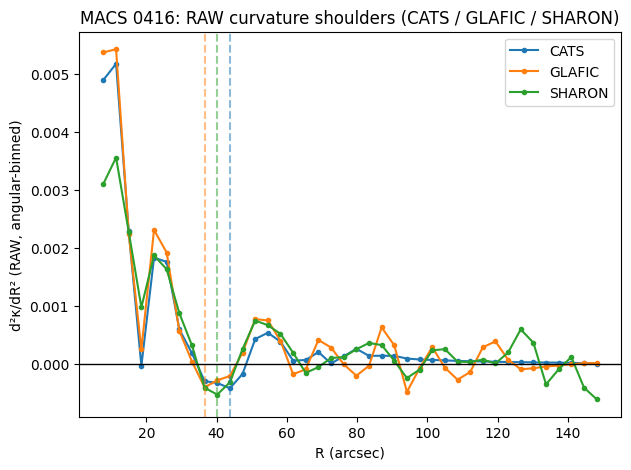

cluster             team  R_sh_arcsec
0  MACS0416    MACS0416_CATS         43.8
1  MACS0416  MACS0416_GLAFIC         36.6
2  MACS0416  MACS0416_SHARON         40.2

In [3]:
# Cell 3: MACS 0416 — CATS / GLAFIC / SHARON

CENTER_RA_0416  = "04:16:09.144"
CENTER_DEC_0416 = "-24:04:02.95"

macs0416_cats = profile_with_angular_bins(
    HFF_OPTIONS[4]["kappa"], CENTER_RA_0416, CENTER_DEC_0416, "MACS0416_CATS"
)
macs0416_shar = profile_with_angular_bins(
    HFF_OPTIONS[5]["kappa"], CENTER_RA_0416, CENTER_DEC_0416, "MACS0416_SHARON"
)
macs0416_glaf = profile_with_angular_bins(
    HFF_OPTIONS[6]["kappa"], CENTER_RA_0416, CENTER_DEC_0416, "MACS0416_GLAFIC"
)

print("MACS 0416 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {macs0416_cats['team']}:   R_sh ≈ {macs0416_cats['R_sh']:.3f}\"")
print(f"  {macs0416_shar['team']}: R_sh ≈ {macs0416_shar['R_sh']:.3f}\"")
print(f"  {macs0416_glaf['team']}: R_sh ≈ {macs0416_glaf['R_sh']:.3f}\"")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(macs0416_cats["R_arcsec"], macs0416_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(macs0416_glaf["R_arcsec"], macs0416_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(macs0416_shar["R_arcsec"], macs0416_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (macs0416_cats, "C0"),
    (macs0416_glaf, "C1"),
    (macs0416_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("MACS 0416: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

df_macs0416 = pd.DataFrame([
    dict(cluster="MACS0416", team=macs0416_cats["team"], R_sh_arcsec=macs0416_cats["R_sh"]),
    dict(cluster="MACS0416", team=macs0416_glaf["team"], R_sh_arcsec=macs0416_glaf["R_sh"]),
    dict(cluster="MACS0416", team=macs0416_shar["team"], R_sh_arcsec=macs0416_shar["R_sh"]),
])
ALL_RESULTS.extend(df_macs0416.to_dict(orient="records"))
df_macs0416


MACS 0717 shoulder radii (angular-binned, RAW curvature, 20–80"):
  MACS0717_CATS:   R_sh ≈ 22.200"
  MACS0717_GLAFIC: R_sh ≈ 36.600"
  MACS0717_SHARON: R_sh ≈ 36.600"


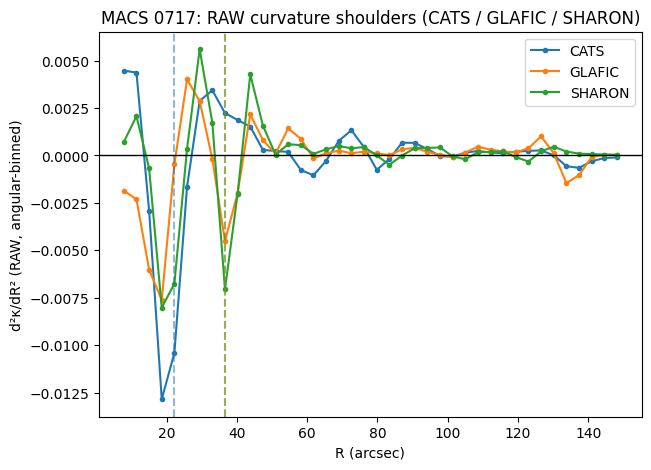

cluster             team  R_sh_arcsec
0  MACS0717    MACS0717_CATS         22.2
1  MACS0717  MACS0717_GLAFIC         36.6
2  MACS0717  MACS0717_SHARON         36.6

In [4]:
# Cell 4: MACS 0717 — CATS / GLAFIC / SHARON

CENTER_RA_0717  = "07:17:33.889"
CENTER_DEC_0717 = "+37:44:44.57"

macs0717_cats = profile_with_angular_bins(
    HFF_OPTIONS[7]["kappa"], CENTER_RA_0717, CENTER_DEC_0717, "MACS0717_CATS"
)
macs0717_glaf = profile_with_angular_bins(
    HFF_OPTIONS[8]["kappa"], CENTER_RA_0717, CENTER_DEC_0717, "MACS0717_GLAFIC"
)
macs0717_shar = profile_with_angular_bins(
    HFF_OPTIONS[9]["kappa"], CENTER_RA_0717, CENTER_DEC_0717, "MACS0717_SHARON"
)

print("MACS 0717 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {macs0717_cats['team']}:   R_sh ≈ {macs0717_cats['R_sh']:.3f}\"")
print(f"  {macs0717_glaf['team']}: R_sh ≈ {macs0717_glaf['R_sh']:.3f}\"")
print(f"  {macs0717_shar['team']}: R_sh ≈ {macs0717_shar['R_sh']:.3f}\"")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(macs0717_cats["R_arcsec"], macs0717_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(macs0717_glaf["R_arcsec"], macs0717_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(macs0717_shar["R_arcsec"], macs0717_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (macs0717_cats, "C0"),
    (macs0717_glaf, "C1"),
    (macs0717_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("MACS 0717: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

df_macs0717 = pd.DataFrame([
    dict(cluster="MACS0717", team=macs0717_cats["team"], R_sh_arcsec=macs0717_cats["R_sh"]),
    dict(cluster="MACS0717", team=macs0717_glaf["team"], R_sh_arcsec=macs0717_glaf["R_sh"]),
    dict(cluster="MACS0717", team=macs0717_shar["team"], R_sh_arcsec=macs0717_shar["R_sh"]),
])
ALL_RESULTS.extend(df_macs0717.to_dict(orient="records"))
df_macs0717


MACS 1149 shoulder radii (angular-binned, RAW curvature, 20–80"):
  MACS1149_CATS:   R_sh ≈ 47.400"
  MACS1149_SHARON: R_sh ≈ 47.400"
  MACS1149_GLAFIC: R_sh ≈ 47.400"


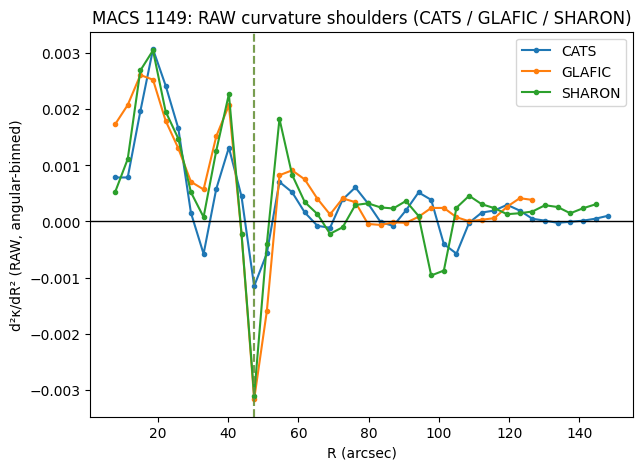

cluster             team  R_sh_arcsec
0  MACS1149    MACS1149_CATS         47.4
1  MACS1149  MACS1149_GLAFIC         47.4
2  MACS1149  MACS1149_SHARON         47.4

In [5]:
# Cell 5: MACS 1149 — CATS / GLAFIC / SHARON

CENTER_RA_1149  = "11:49:35.28"
CENTER_DEC_1149 = "+22:23:55.5"

macs1149_cats = profile_with_angular_bins(
    HFF_OPTIONS[10]["kappa"], CENTER_RA_1149, CENTER_DEC_1149, "MACS1149_CATS"
)
macs1149_shar = profile_with_angular_bins(
    HFF_OPTIONS[11]["kappa"], CENTER_RA_1149, CENTER_DEC_1149, "MACS1149_SHARON"
)
macs1149_glaf = profile_with_angular_bins(
    HFF_OPTIONS[12]["kappa"], CENTER_RA_1149, CENTER_DEC_1149, "MACS1149_GLAFIC"
)

print("MACS 1149 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {macs1149_cats['team']}:   R_sh ≈ {macs1149_cats['R_sh']:.3f}\"")
print(f"  {macs1149_shar['team']}: R_sh ≈ {macs1149_shar['R_sh']:.3f}\"")
print(f"  {macs1149_glaf['team']}: R_sh ≈ {macs1149_glaf['R_sh']:.3f}\"")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(macs1149_cats["R_arcsec"], macs1149_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(macs1149_glaf["R_arcsec"], macs1149_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(macs1149_shar["R_arcsec"], macs1149_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (macs1149_cats, "C0"),
    (macs1149_glaf, "C1"),
    (macs1149_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("MACS 1149: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

df_macs1149 = pd.DataFrame([
    dict(cluster="MACS1149", team=macs1149_cats["team"], R_sh_arcsec=macs1149_cats["R_sh"]),
    dict(cluster="MACS1149", team=macs1149_glaf["team"], R_sh_arcsec=macs1149_glaf["R_sh"]),
    dict(cluster="MACS1149", team=macs1149_shar["team"], R_sh_arcsec=macs1149_shar["R_sh"]),
])
ALL_RESULTS.extend(df_macs1149.to_dict(orient="records"))
df_macs1149


ABELLS 1063 shoulder radii (angular-binned, RAW curvature, 20–80"):
  ABELLS1063_CATS:   R_sh ≈ 76.200"
  ABELLS1063_GLAFIC: R_sh ≈ 76.200"
  ABELLS1063_SHARON: R_sh ≈ 76.200"


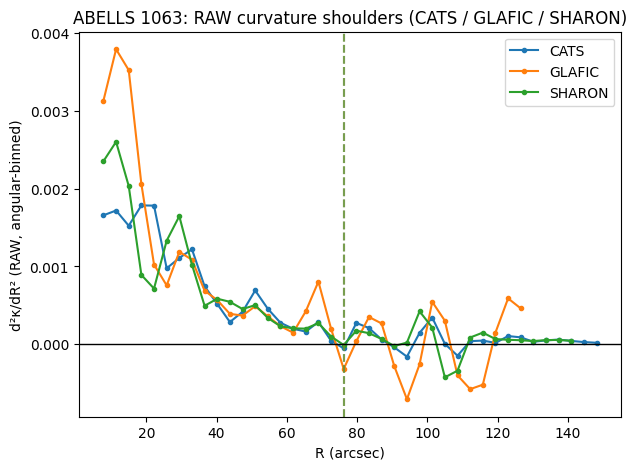

cluster               team  R_sh_arcsec
0  ABELLS1063    ABELLS1063_CATS         76.2
1  ABELLS1063  ABELLS1063_GLAFIC         76.2
2  ABELLS1063  ABELLS1063_SHARON         76.2

In [6]:
# Cell 6: ABELLS 1063 — CATS / GLAFIC / SHARON

CENTER_RA_S1063  = "22:48:43.973"
CENTER_DEC_S1063 = "-44:31:51.20"

s1063_cats = profile_with_angular_bins(
    HFF_OPTIONS[13]["kappa"], CENTER_RA_S1063, CENTER_DEC_S1063, "ABELLS1063_CATS"
)
s1063_glaf = profile_with_angular_bins(
    HFF_OPTIONS[14]["kappa"], CENTER_RA_S1063, CENTER_DEC_S1063, "ABELLS1063_GLAFIC"
)
s1063_shar = profile_with_angular_bins(
    HFF_OPTIONS[15]["kappa"], CENTER_RA_S1063, CENTER_DEC_S1063, "ABELLS1063_SHARON"
)

print("ABELLS 1063 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {s1063_cats['team']}:   R_sh ≈ {s1063_cats['R_sh']:.3f}\"")
print(f"  {s1063_glaf['team']}: R_sh ≈ {s1063_glaf['R_sh']:.3f}\"")
print(f"  {s1063_shar['team']}: R_sh ≈ {s1063_shar['R_sh']:.3f}\"")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(s1063_cats["R_arcsec"], s1063_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(s1063_glaf["R_arcsec"], s1063_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(s1063_shar["R_arcsec"], s1063_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (s1063_cats, "C0"),
    (s1063_glaf, "C1"),
    (s1063_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("ABELLS 1063: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

df_s1063 = pd.DataFrame([
    dict(cluster="ABELLS1063", team=s1063_cats["team"], R_sh_arcsec=s1063_cats["R_sh"]),
    dict(cluster="ABELLS1063", team=s1063_glaf["team"], R_sh_arcsec=s1063_glaf["R_sh"]),
    dict(cluster="ABELLS1063", team=s1063_shar["team"], R_sh_arcsec=s1063_shar["R_sh"]),
])
ALL_RESULTS.extend(df_s1063.to_dict(orient="records"))
df_s1063


ABELL 370 shoulder radii (angular-binned, RAW curvature, 20–80"):
  ABELL370_CATS:   R_sh ≈ 51.000"
  ABELL370_GLAFIC: R_sh ≈ 22.200"
  ABELL370_SHARON: R_sh ≈ 51.000"


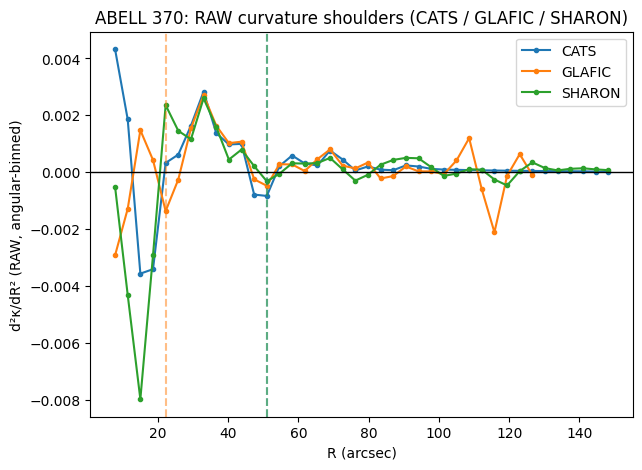

cluster             team  R_sh_arcsec
0  ABELL370    ABELL370_CATS         51.0
1  ABELL370  ABELL370_GLAFIC         22.2
2  ABELL370  ABELL370_SHARON         51.0

In [7]:
# Cell 7: ABELL 370 — CATS / GLAFIC / SHARON

CENTER_RA_370  = "02:39:52.82"
CENTER_DEC_370 = "-01:34:35.3"

a370_cats = profile_with_angular_bins(
    HFF_OPTIONS[16]["kappa"], CENTER_RA_370, CENTER_DEC_370, "ABELL370_CATS"
)
a370_glaf = profile_with_angular_bins(
    HFF_OPTIONS[17]["kappa"], CENTER_RA_370, CENTER_DEC_370, "ABELL370_GLAFIC"
)
a370_shar = profile_with_angular_bins(
    HFF_OPTIONS[18]["kappa"], CENTER_RA_370, CENTER_DEC_370, "ABELL370_SHARON"
)

print("ABELL 370 shoulder radii (angular-binned, RAW curvature, 20–80\"):")
print(f"  {a370_cats['team']}:   R_sh ≈ {a370_cats['R_sh']:.3f}\"")
print(f"  {a370_glaf['team']}: R_sh ≈ {a370_glaf['R_sh']:.3f}\"")
print(f"  {a370_shar['team']}: R_sh ≈ {a370_shar['R_sh']:.3f}\"")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(a370_cats["R_arcsec"], a370_cats["d2k"], "o-", ms=3, label="CATS")
ax.plot(a370_glaf["R_arcsec"], a370_glaf["d2k"], "o-", ms=3, label="GLAFIC")
ax.plot(a370_shar["R_arcsec"], a370_shar["d2k"], "o-", ms=3, label="SHARON")

for prof, col in [
    (a370_cats, "C0"),
    (a370_glaf, "C1"),
    (a370_shar, "C2"),
]:
    if not np.isnan(prof["R_sh"]):
        ax.axvline(prof["R_sh"], ls="--", color=col, alpha=0.5)

ax.axhline(0, color="k", lw=1)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("d²κ/dR² (RAW, angular-binned)")
ax.set_title("ABELL 370: RAW curvature shoulders (CATS / GLAFIC / SHARON)")
ax.legend()
plt.show()

df_a370 = pd.DataFrame([
    dict(cluster="ABELL370", team=a370_cats["team"], R_sh_arcsec=a370_cats["R_sh"]),
    dict(cluster="ABELL370", team=a370_glaf["team"], R_sh_arcsec=a370_glaf["R_sh"]),
    dict(cluster="ABELL370", team=a370_shar["team"], R_sh_arcsec=a370_shar["R_sh"]),
])
ALL_RESULTS.extend(df_a370.to_dict(orient="records"))
df_a370


In [8]:
# Cell 8: consolidate all results into a single benchmark table

if not ALL_RESULTS:
    raise RuntimeError("ALL_RESULTS is empty – run the cluster cells first.")

results_df = pd.DataFrame(ALL_RESULTS)

# attach z_lens from HFF_OPTIONS (by TAG)
tag_to_z = {v["TAG"]: v["z"] for v in HFF_OPTIONS.values()}
results_df["z_lens"] = results_df["team"].map(
    lambda t: next(z for tag, z in tag_to_z.items() if t.split("_")[0] in tag)
)

results_df = results_df[["cluster", "team", "z_lens", "R_sh_arcsec"]].sort_values(
    ["cluster", "team"]
).reset_index(drop=True)

display(results_df)

results_df.to_csv("HFF_shoulders_20_80arcsec_rawcurv_benchmark.csv", index=False)
print("Saved: HFF_shoulders_20_80arcsec_rawcurv_benchmark.csv")


cluster               team  z_lens  R_sh_arcsec
0    ABELL2744     ABELL2744_CATS   0.308         43.8
1    ABELL2744   ABELL2744_GLAFIC   0.308         65.4
2    ABELL2744   ABELL2744_SHARON   0.308         65.4
3     ABELL370      ABELL370_CATS   0.375         51.0
4     ABELL370    ABELL370_GLAFIC   0.375         22.2
5     ABELL370    ABELL370_SHARON   0.375         51.0
6   ABELLS1063    ABELLS1063_CATS   0.348         76.2
7   ABELLS1063  ABELLS1063_GLAFIC   0.348         76.2
8   ABELLS1063  ABELLS1063_SHARON   0.348         76.2
9     MACS0416      MACS0416_CATS   0.396         43.8
10    MACS0416    MACS0416_GLAFIC   0.396         36.6
11    MACS0416    MACS0416_SHARON   0.396         40.2
12    MACS0717      MACS0717_CATS   0.546         22.2
13    MACS0717    MACS0717_GLAFIC   0.546         36.6
14    MACS0717    MACS0717_SHARON   0.546         36.6
15    MACS1149      MACS1149_CATS   0.544         47.4
16    MACS1149    MACS1149_GLAFIC   0.544         47.4
17    MACS1149    MACS1149_SHARON   0.544         47.4

Saved: HFF_shoulders_20_80arcsec_rawcurv_benchmark.csv


In [9]:
# Cell: Convert shoulder radii from arcsec → kpc using angular-diameter distance

from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import numpy as np

# results_df must already exist and contain:
#   cluster, team, z_lens, R_sh_arcsec

def arcsec_to_kpc(R_arcsec, z):
    """
    Convert angular radius (arcsec) to physical radius (kpc)
    using angular-diameter distance at redshift z.
    """
    if np.isnan(R_arcsec):
        return np.nan
    # convert arcsec → radians
    theta = (R_arcsec * u.arcsec).to(u.radian)
    # angular diameter distance in kpc
    D_A = cosmo.angular_diameter_distance(z).to(u.kpc)
    # R = theta * D_A
    R_kpc = (theta * D_A).value
    return R_kpc

# Compute R_sh in kpc
results_df["R_sh_kpc"] = results_df.apply(
    lambda row: arcsec_to_kpc(row["R_sh_arcsec"], row["z_lens"]),
    axis=1
)

# Display final table with both units
display(results_df[["cluster", "team", "z_lens", "R_sh_arcsec", "R_sh_kpc"]])

# Optional: save as CSV
results_df.to_csv("HFF_shoulders_with_kpc.csv", index=False)
print("Saved: HFF_shoulders_with_kpc.csv")


cluster               team  z_lens  R_sh_arcsec    R_sh_kpc
0    ABELL2744     ABELL2744_CATS   0.308         43.8  205.025598
1    ABELL2744   ABELL2744_GLAFIC   0.308         65.4  306.134112
2    ABELL2744   ABELL2744_SHARON   0.308         65.4  306.134112
3     ABELL370      ABELL370_CATS   0.375         51.0  271.581740
4     ABELL370    ABELL370_GLAFIC   0.375         22.2  118.217934
5     ABELL370    ABELL370_SHARON   0.375         51.0  271.581740
6   ABELLS1063    ABELLS1063_CATS   0.348         76.2  386.899378
7   ABELLS1063  ABELLS1063_GLAFIC   0.348         76.2  386.899378
8   ABELLS1063  ABELLS1063_SHARON   0.348         76.2  386.899378
9     MACS0416      MACS0416_CATS   0.396         43.8  241.225724
10    MACS0416    MACS0416_GLAFIC   0.396         36.6  201.572181
11    MACS0416    MACS0416_SHARON   0.396         40.2  221.398952
12    MACS0717      MACS0717_CATS   0.546         22.2  146.115973
13    MACS0717    MACS0717_GLAFIC   0.546         36.6  240.893901
14    MACS0717    MACS0717_SHARON   0.546         36.6  240.893901
15    MACS1149      MACS1149_CATS   0.544         47.4  311.408209
16    MACS1149    MACS1149_GLAFIC   0.544         47.4  311.408209
17    MACS1149    MACS1149_SHARON   0.544         47.4  311.408209

Saved: HFF_shoulders_with_kpc.csv


In [11]:
# Cell: Edge-coverage diagnostic – check shoulders vs map edges

import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# --- same helper as in main analysis ---
def pixel_scale_arcsec(header):
    if "CDELT1" in header:
        val = header["CDELT1"]
    elif "CD1_1" in header:
        val = header["CD1_1"]
    else:
        raise RuntimeError("No CDELT1/CD1_1 in header.")
    return abs(val) * 3600.0

# cluster centres (same as in your analysis cells)
CENTRES = {
    "ABELL2744":  ("00:14:20.312",  "-30:23:18.10"),
    "MACS0416":   ("04:16:09.144",  "-24:04:02.95"),
    "MACS0717":   ("07:17:33.889",  "+37:44:44.57"),
    "MACS1149":   ("11:49:35.28",   "+22:23:55.5"),
    "ABELLS1063": ("22:48:43.973",  "-44:31:51.20"),
    "ABELL370":   ("02:39:52.82",   "-01:34:35.3"),
}

EDGE_OUTER_ARCSEC   = 200.0   # diagnostics only: look further than 150"
EDGE_N_BINS         = 50
EDGE_THRESHOLD      = 0.9     # where coverage drops below 90%

def edge_radius_for_map(kappa_path, ra_str, dec_str):
    """
    Diagnostic only: for one map, compute valid_fraction vs R and
    return the first radius where valid_fraction < EDGE_THRESHOLD.
    """
    hdul = fits.open(kappa_path)
    data = hdul[0].data
    hdr  = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pixscale = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    cx, cy = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    cx, cy = float(cx), float(cy)

    ny, nx = data.shape
    yy, xx = np.indices(data.shape)
    r_pix = np.sqrt((xx - cx)**2 + (yy - cy)**2)

    valid = np.ones_like(data, dtype=bool)
    valid &= ~np.isnan(data)
    valid &= (data != 0.0)

    edges_arc = np.linspace(0.0, EDGE_OUTER_ARCSEC, EDGE_N_BINS + 1)
    edges_pix = edges_arc / pixscale
    mids_arc  = 0.5 * (edges_arc[:-1] + edges_arc[1:])

    frac = []
    for rmin_pix, rmax_pix in zip(edges_pix[:-1], edges_pix[1:]):
        ann = (r_pix >= rmin_pix) & (r_pix < rmax_pix)
        tot = ann.sum()
        if tot == 0:
            frac.append(0.0)
            continue
        good = ann & valid
        frac.append(good.sum() / tot)

    frac = np.array(frac)
    mids_arc = np.array(mids_arc)

    # first radius where coverage drops below threshold
    bad = frac < EDGE_THRESHOLD
    if not np.any(bad):
        return np.nan  # no obvious edge within EDGE_OUTER_ARCSEC
    return float(mids_arc[bad][0])

# Now loop over each row in results_df and compare R_sh vs edge radius
rows = []
for _, row in results_df.iterrows():
    cluster = row["cluster"]
    team    = row["team"]
    R_sh    = row["R_sh_arcsec"]

    ra_str, dec_str = CENTRES[cluster]
    # find the matching HFF_OPTIONS entry by TAG
    tag = team
    # team strings like "ABELL2744_CATS" already match TAG
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    R_edge = edge_radius_for_map(kappa_path, ra_str, dec_str)

    rows.append(dict(
        cluster=cluster,
        team=team,
        R_sh_arcsec=R_sh,
        R_edge90_arcsec=R_edge,
        margin_arcsec=(R_edge - R_sh) if (not np.isnan(R_edge) and not np.isnan(R_sh)) else np.nan,
    ))

edge_df = pd.DataFrame(rows).sort_values(["cluster", "team"]).reset_index(drop=True)
display(edge_df)


cluster               team  R_sh_arcsec  R_edge90_arcsec  margin_arcsec
0    ABELL2744     ABELL2744_CATS         43.8              NaN            NaN
1    ABELL2744   ABELL2744_GLAFIC         65.4            158.0           92.6
2    ABELL2744   ABELL2744_SHARON         65.4            182.0          116.6
3     ABELL370      ABELL370_CATS         51.0              NaN            NaN
4     ABELL370    ABELL370_GLAFIC         22.2            130.0          107.8
5     ABELL370    ABELL370_SHARON         51.0            162.0          111.0
6   ABELLS1063    ABELLS1063_CATS         76.2              NaN            NaN
7   ABELLS1063  ABELLS1063_GLAFIC         76.2            130.0           53.8
8   ABELLS1063  ABELLS1063_SHARON         76.2            146.0           69.8
9     MACS0416      MACS0416_CATS         43.8              NaN            NaN
10    MACS0416    MACS0416_GLAFIC         36.6            154.0          117.4
11    MACS0416    MACS0416_SHARON         40.2            162.0          121.8
12    MACS0717      MACS0717_CATS         22.2              NaN            NaN
13    MACS0717    MACS0717_GLAFIC         36.6            186.0          149.4
14    MACS0717    MACS0717_SHARON         36.6            162.0          125.4
15    MACS1149      MACS1149_CATS         47.4              NaN            NaN
16    MACS1149    MACS1149_GLAFIC         47.4            130.0           82.6
17    MACS1149    MACS1149_SHARON         47.4            150.0          102.6

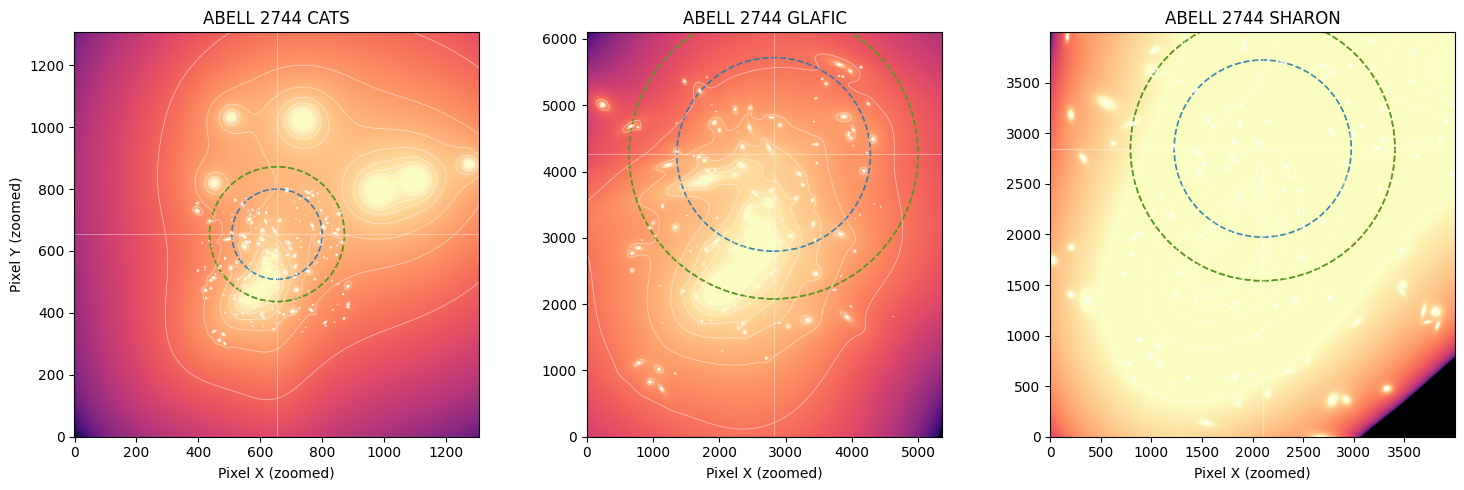

In [29]:
# Cell: ABELL 2744 – 3-panel κ–maps (CATS / GLAFIC / SHARON)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "ABELL2744"]
shoulders_arcsec = {row["team"]: row["R_sh_arcsec"] for _, row in df_cl.iterrows()}
max_R = df_cl["R_sh_arcsec"].max()

teams = [
    ("ABELL2744_CATS",   "CATS"),
    ("ABELL2744_GLAFIC", "GLAFIC"),
    ("ABELL2744_SHARON", "SHARON"),
]

ra_str, dec_str = CENTRES["ABELL2744"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)
    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))
    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.5, alpha=0.6)

    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    for team_full, color in [
        ("ABELL2744_CATS", "C0"),
        ("ABELL2744_GLAFIC", "C1"),
        ("ABELL2744_SHARON", "C2"),
    ]:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
        )
        ax.add_patch(circ)

    ax.set_title(f"ABELL 2744 {label}", fontsize=12)
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


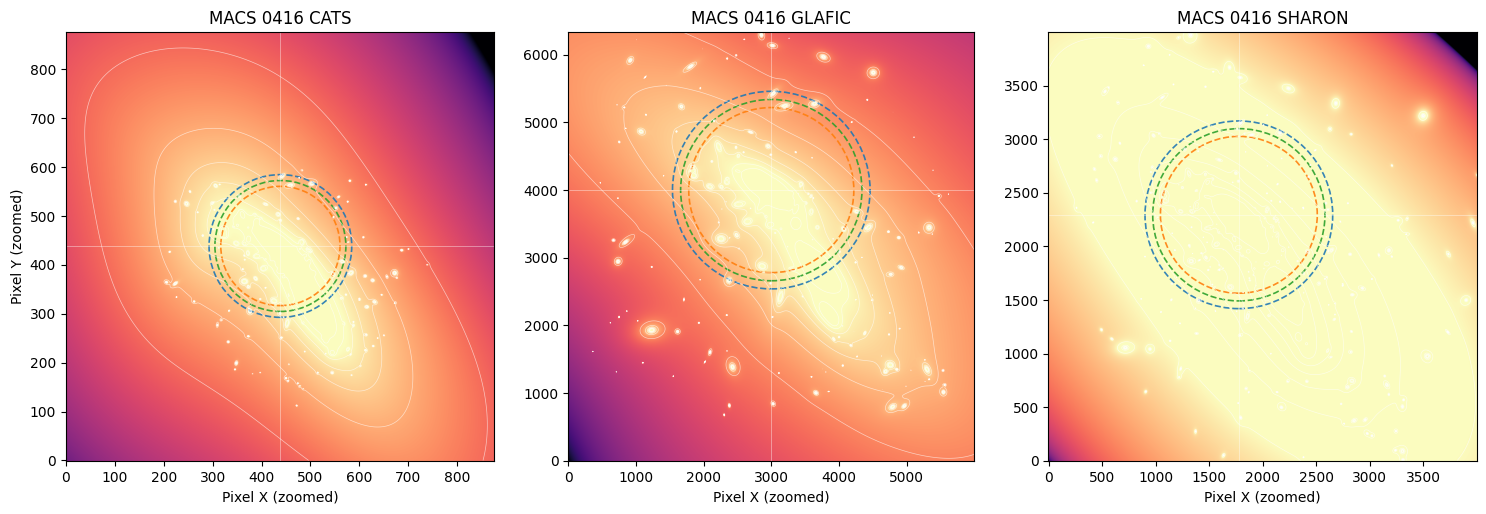

In [28]:
# Cell: MACS 0416 – 3-panel κ–maps (CATS / GLAFIC / SHARON)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "MACS0416"]
shoulders_arcsec = {row["team"]: row["R_sh_arcsec"] for _, row in df_cl.iterrows()}
max_R = df_cl["R_sh_arcsec"].max()

teams = [
    ("MACS0416_CATS",   "CATS"),
    ("MACS0416_GLAFIC", "GLAFIC"),
    ("MACS0416_SHARON", "SHARON"),
]

ra_str, dec_str = CENTRES["MACS0416"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)
    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))
    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.5, alpha=0.6)

    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    for team_full, color in [
        ("MACS0416_CATS", "C0"),
        ("MACS0416_GLAFIC", "C1"),
        ("MACS0416_SHARON", "C2"),
    ]:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
        )
        ax.add_patch(circ)

    ax.set_title(f"MACS 0416 {label}", fontsize=12)
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


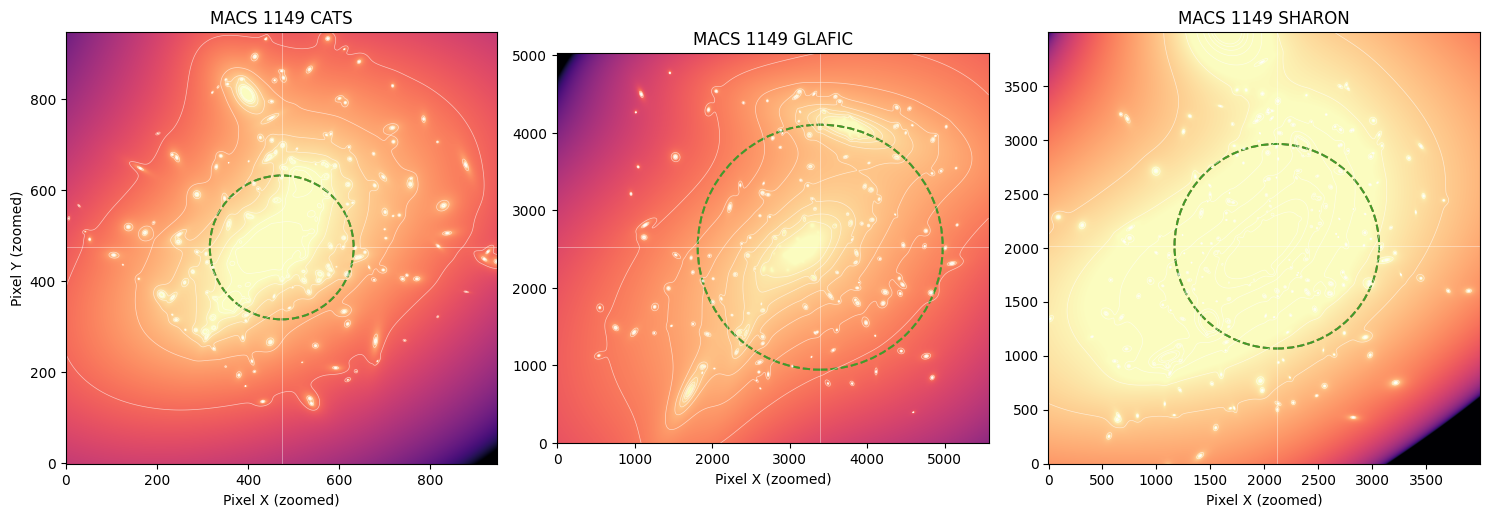

In [18]:
# Cell: MACS1149 – 3-panel figure (CATS / GLAFIC / SHARON)
# κ–map + κ–contours + all three shoulder circles (no colorbar, no legend)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

# --- Shoulders for all three maps in arcsec ---
df_m1149 = results_df[results_df["cluster"] == "MACS1149"]

shoulders_arcsec = {
    row["team"]: row["R_sh_arcsec"]
    for _, row in df_m1149.iterrows()
}

# --- Teams and labels ---
teams = [
    ("MACS1149_CATS",   "CATS"),
    ("MACS1149_GLAFIC", "GLAFIC"),
    ("MACS1149_SHARON", "SHARON"),
]

# --- Centre coordinates ---
ra_str, dec_str = CENTRES["MACS1149"]

# --- Set up figure ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):

    # load κ-map
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    # centre in pixels
    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    # zoom region (same logic: 3× max shoulder radius)
    max_R = df_m1149["R_sh_arcsec"].max()
    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)

    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))

    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    # --- main κ image ---
    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    # --- κ contours ---
    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    contour_levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=contour_levels, colors="white", linewidths=0.5, alpha=0.6)

    # centre crosshair
    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    # --- all shoulder circles (CATS/GLAFIC/SHARON) ---
    circle_specs = [
        ("MACS1149_CATS",   "C0"),
        ("MACS1149_GLAFIC", "C1"),
        ("MACS1149_SHARON", "C2"),
    ]
    for team_full, color in circle_specs:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.4,
            alpha=0.9,
        )
        ax.add_patch(circ)

    # --- Panel title ---
    ax.set_title(f"MACS 1149 {label}", fontsize=12)

    # --- Axis labels, identical style ---
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")

    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


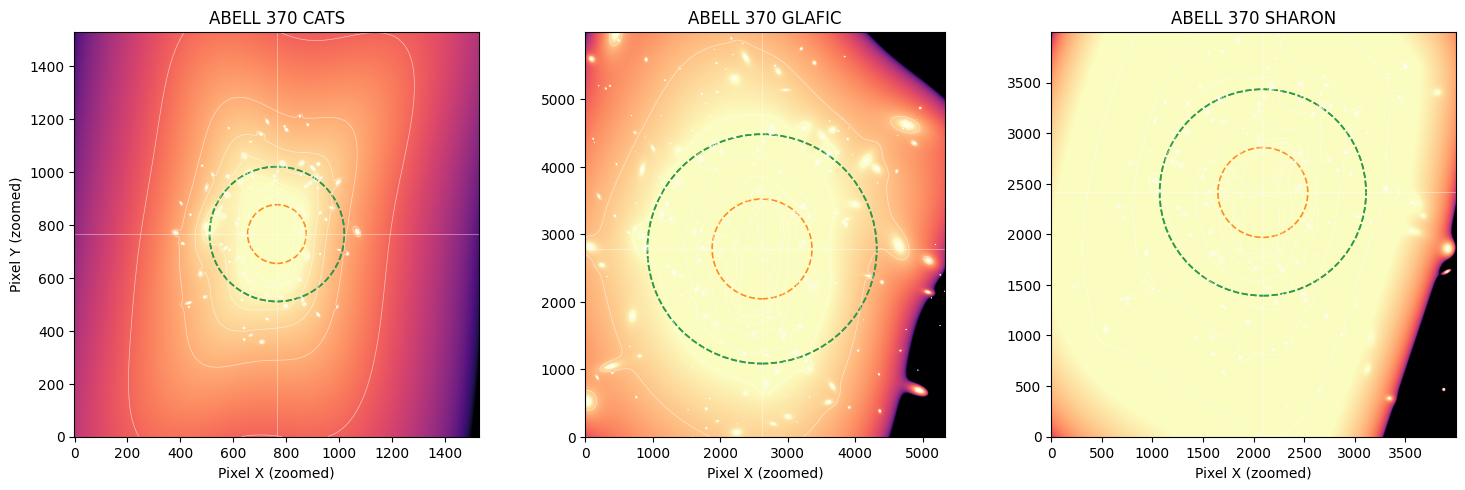

In [25]:
# Cell: ABELL 370 – 3-panel κ–maps (CATS / GLAFIC / SHARON)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "ABELL370"]
shoulders_arcsec = {row["team"]: row["R_sh_arcsec"] for _, row in df_cl.iterrows()}
max_R = df_cl["R_sh_arcsec"].max()

teams = [
    ("ABELL370_CATS",   "CATS"),
    ("ABELL370_GLAFIC", "GLAFIC"),
    ("ABELL370_SHARON", "SHARON"),
]

ra_str, dec_str = CENTRES["ABELL370"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)
    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))
    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.5, alpha=0.6)

    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    for team_full, color in [
        ("ABELL370_CATS", "C0"),
        ("ABELL370_GLAFIC", "C1"),
        ("ABELL370_SHARON", "C2"),
    ]:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
        )
        ax.add_patch(circ)

    ax.set_title(f"ABELL 370 {label}", fontsize=12)
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


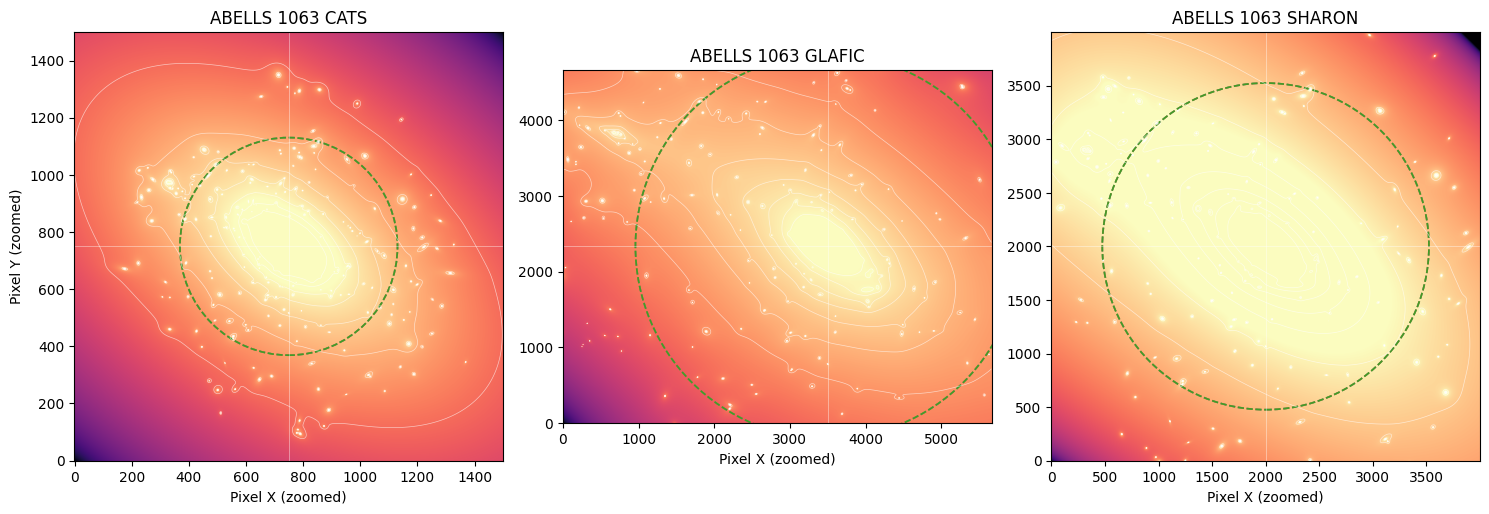

In [26]:
# Cell: ABELLS 1063 – 3-panel κ–maps (CATS / GLAFIC / SHARON)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "ABELLS1063"]
shoulders_arcsec = {row["team"]: row["R_sh_arcsec"] for _, row in df_cl.iterrows()}
max_R = df_cl["R_sh_arcsec"].max()

teams = [
    ("ABELLS1063_CATS",   "CATS"),
    ("ABELLS1063_GLAFIC", "GLAFIC"),
    ("ABELLS1063_SHARON", "SHARON"),
]

ra_str, dec_str = CENTRES["ABELLS1063"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)
    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))
    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.5, alpha=0.6)

    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    for team_full, color in [
        ("ABELLS1063_CATS", "C0"),
        ("ABELLS1063_GLAFIC", "C1"),
        ("ABELLS1063_SHARON", "C2"),
    ]:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
        )
        ax.add_patch(circ)

    ax.set_title(f"ABELLS 1063 {label}", fontsize=12)
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


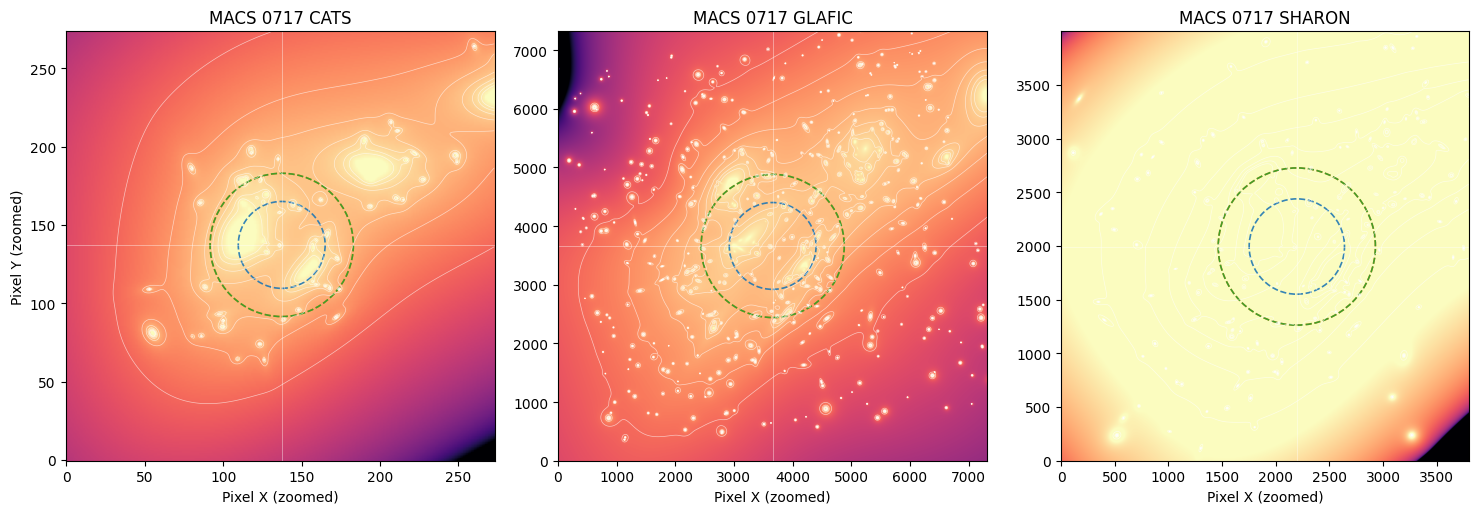

In [27]:
# Cell: MACS 0717 – 3-panel κ–maps (CATS / GLAFIC / SHARON)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "MACS0717"]
shoulders_arcsec = {row["team"]: row["R_sh_arcsec"] for _, row in df_cl.iterrows()}
max_R = df_cl["R_sh_arcsec"].max()

teams = [
    ("MACS0717_CATS",   "CATS"),
    ("MACS0717_GLAFIC", "GLAFIC"),
    ("MACS0717_SHARON", "SHARON"),
]

ra_str, dec_str = CENTRES["MACS0717"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (tag, label) in zip(axes, teams):
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
    kappa_path = opt["kappa"]

    hdul = fits.open(kappa_path)
    kappa = hdul[0].data
    hdr   = hdul[0].header
    hdul.close()

    w = WCS(hdr)
    pix_scale_arcsec = pixel_scale_arcsec(hdr)

    coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
    x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
    x0, y0 = float(x0), float(y0)

    zoom_radius_pix = 3.0 * (max_R / pix_scale_arcsec)
    ny, nx = kappa.shape
    x_min = max(0, int(x0 - zoom_radius_pix))
    x_max = min(nx, int(x0 + zoom_radius_pix))
    y_min = max(0, int(y0 - zoom_radius_pix))
    y_max = min(ny, int(y0 + zoom_radius_pix))
    kappa_zoom = kappa[y_min:y_max, x_min:x_max]

    norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
    ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

    finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
    vmin = np.percentile(finite_vals, 40)
    vmax = np.percentile(finite_vals, 98)
    levels = np.linspace(vmin, vmax, 7)
    ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.5, alpha=0.6)

    x0_zoom = x0 - x_min
    y0_zoom = y0 - y_min
    ax.axhline(y0_zoom, color="white", alpha=0.4, linewidth=0.7)
    ax.axvline(x0_zoom, color="white", alpha=0.4, linewidth=0.7)

    for team_full, color in [
        ("MACS0717_CATS", "C0"),
        ("MACS0717_GLAFIC", "C1"),
        ("MACS0717_SHARON", "C2"),
    ]:
        R_sh_arcsec = shoulders_arcsec[team_full]
        R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
        circ = Circle(
            (x0_zoom, y0_zoom),
            R_sh_pix,
            edgecolor=color,
            facecolor="none",
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
        )
        ax.add_patch(circ)

    ax.set_title(f"MACS 0717 {label}", fontsize=12)
    ax.set_xlabel("Pixel X (zoomed)")
    if ax is axes[0]:
        ax.set_ylabel("Pixel Y (zoomed)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


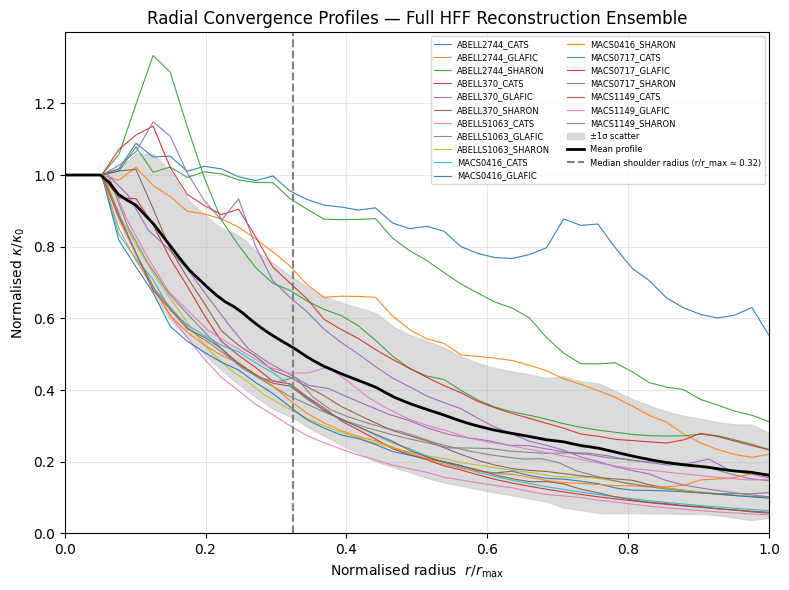

In [12]:
# Cell: Radial Convergence Profiles – full HFF ensemble (all 18 reconstructions)

import numpy as np
import matplotlib.pyplot as plt

# Assumes already defined:
#   - HFF_OPTIONS (with TAG and kappa path)
#   - CENTRES (cluster -> RA,DEC)
#   - results_df, with columns: cluster, team, R_sh_arcsec
#   - profile_with_angular_bins(kappa_path, ra_str, dec_str, team_label)

profiles = []          # list of dicts: {cluster, team, r_norm, k_norm, r_sh_norm}
r_sh_norm_list = []    # to compute ensemble median shoulder radius
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, row in results_df.iterrows():
    cluster = row["cluster"]
    team_tag = row["team"]          # e.g. "MACS1149_CATS"
    R_sh_arcsec = float(row["R_sh_arcsec"])

    # find kappa path from HFF_OPTIONS
    opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == team_tag)
    kappa_path = opt["kappa"]

    # centre RA/Dec
    ra_str, dec_str = CENTRES[cluster]

    # compute radial profile (angular-binned, RAW curvature pipeline)
    prof = profile_with_angular_bins(kappa_path, ra_str, dec_str, team_tag)
    R_arc = np.asarray(prof["R_arcsec"])
    kappa_mean = np.asarray(prof["kappa_mean"])

    # keep only finite bins
    mask = np.isfinite(R_arc) & np.isfinite(kappa_mean)
    if not np.any(mask):
        continue

    R_arc = R_arc[mask]
    kappa_mean = kappa_mean[mask]

    # sort by radius just in case
    order = np.argsort(R_arc)
    R_arc = R_arc[order]
    kappa_mean = kappa_mean[order]

    # define r_max for this map and normalise radius
    r_max = R_arc.max()
    r_norm = R_arc / r_max

    # normalise κ so that innermost valid bin is 1
    k0 = kappa_mean[0]
    if k0 == 0:
        # if the very first bin is zero (unlikely with our masks), skip this map
        continue
    k_norm = kappa_mean / k0

    # normalised shoulder radius for this map
    r_sh_norm = R_sh_arcsec / r_max
    r_sh_norm_list.append(r_sh_norm)

    profiles.append(dict(
        cluster=cluster,
        team=team_tag,
        r_norm=r_norm,
        k_norm=k_norm,
        r_sh_norm=r_sh_norm,
    ))

# common r-grid for ensemble statistics
r_grid = np.linspace(0.0, 1.0, 80)

# interpolate each profile onto the common grid
k_interp_all = []
for prof in profiles:
    r = prof["r_norm"]
    k = prof["k_norm"]
    # np.interp requires increasing x, already sorted
    k_interp = np.interp(r_grid, r, k)
    k_interp_all.append(k_interp)

k_interp_all = np.array(k_interp_all)  # shape: (N_profiles, N_grid)
k_mean = np.mean(k_interp_all, axis=0)
k_std  = np.std(k_interp_all, axis=0)

# ensemble median shoulder radius in r/r_max units
r_sh_med = np.median(r_sh_norm_list)

# --- plot ---
fig, ax = plt.subplots(figsize=(8, 6))

# plot each individual profile
for i, prof in enumerate(profiles):
    col = colors[i % len(colors)]
    label = prof["team"]
    ax.plot(prof["r_norm"], prof["k_norm"], lw=0.8, alpha=0.9, label=label)

# ±1σ band
ax.fill_between(
    r_grid, k_mean - k_std, k_mean + k_std,
    color="0.8", alpha=0.7, label="±1σ scatter"
)

# mean profile
ax.plot(r_grid, k_mean, color="k", lw=2.0, label="Mean profile")

# median shoulder radius
ax.axvline(r_sh_med, color="grey", lw=1.5, ls="--",
           label=f"Median shoulder radius (r/r_max ≈ {r_sh_med:.2f})")

ax.set_xlim(0.0, 1.0)
ax.set_ylim(bottom=0.0)

ax.set_xlabel(r"Normalised radius  $r/r_{\max}$")
ax.set_ylabel(r"Normalised $\kappa / \kappa_0$")
ax.set_title("Radial Convergence Profiles — Full HFF Reconstruction Ensemble")

ax.grid(alpha=0.3)
ax.legend(fontsize=6, ncol=2, frameon=True)

plt.tight_layout()
plt.show()


#test plots

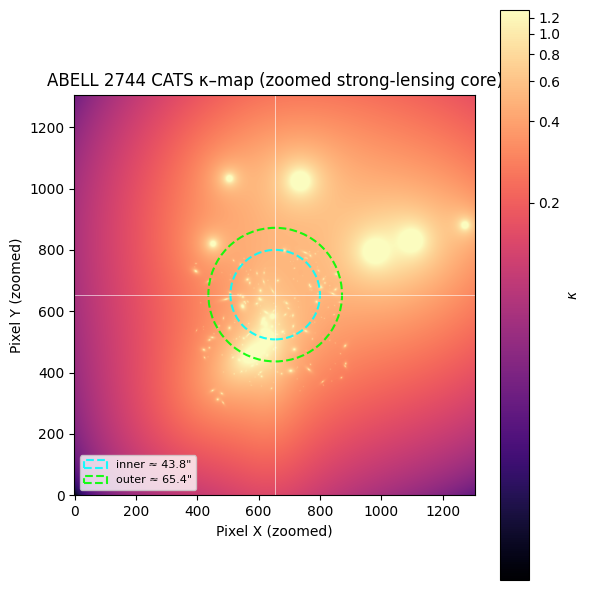

In [13]:
# Cell A: ABELL 2744 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

# 1) Inner/outer shoulders for this cluster (from results_df)
df_cl = results_df[results_df["cluster"] == "ABELL2744"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

# 2) Load CATS κ–map and centre
tag = "ABELL2744_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["ABELL2744"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

# 3) Radii in pixels
inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("ABELL 2744 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

# re-centre coordinates for zoomed subimage
x0_zoom = x0 - x_min
y0_zoom = y0 - y_min

# centre crosshair
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

# shoulder circles
for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


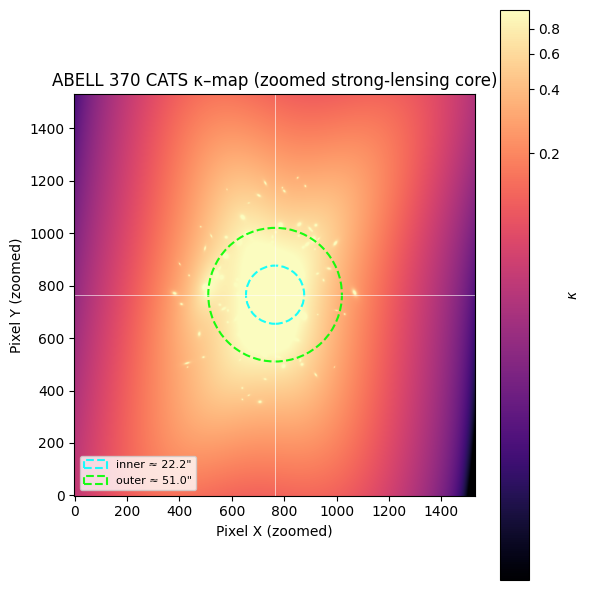

In [19]:
# Cell B: ABELL 370 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "ABELL370"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

tag = "ABELL370_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["ABELL370"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("ABELL 370 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


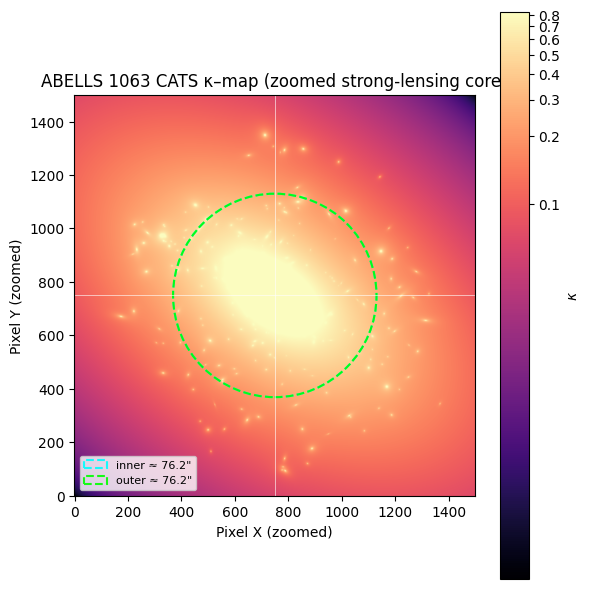

In [20]:
# Cell C: ABELLS 1063 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "ABELLS1063"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

tag = "ABELLS1063_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["ABELLS1063"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("ABELLS 1063 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


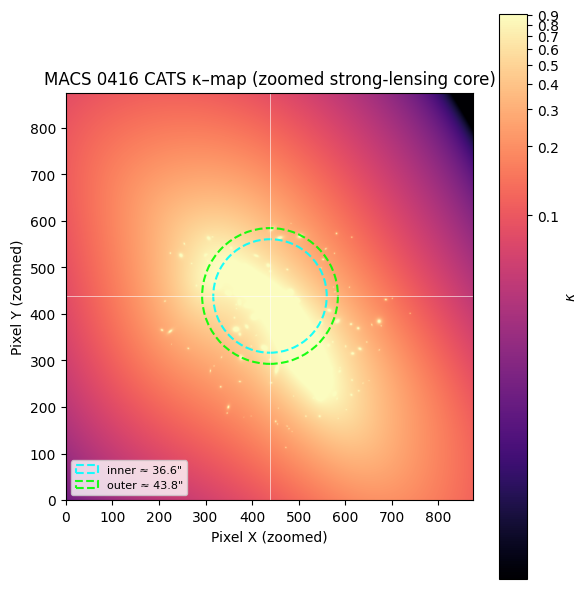

In [21]:
# Cell D: MACS 0416 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "MACS0416"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

tag = "MACS0416_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["MACS0416"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("MACS 0416 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


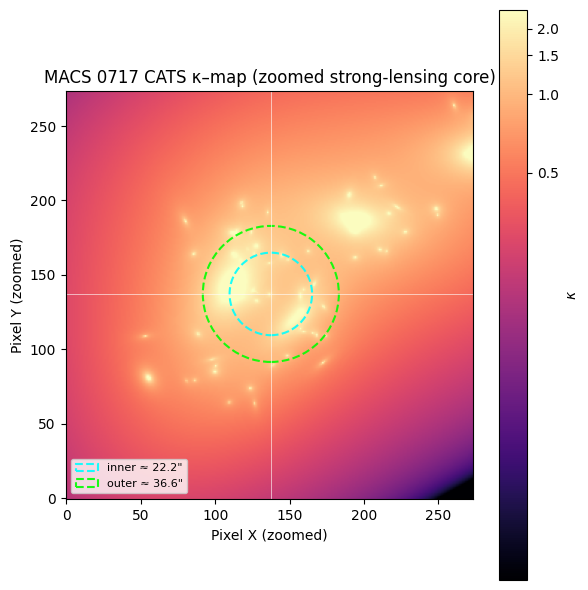

In [22]:
# Cell E: MACS 0717 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "MACS0717"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

tag = "MACS0717_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["MACS0717"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("MACS 0717 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


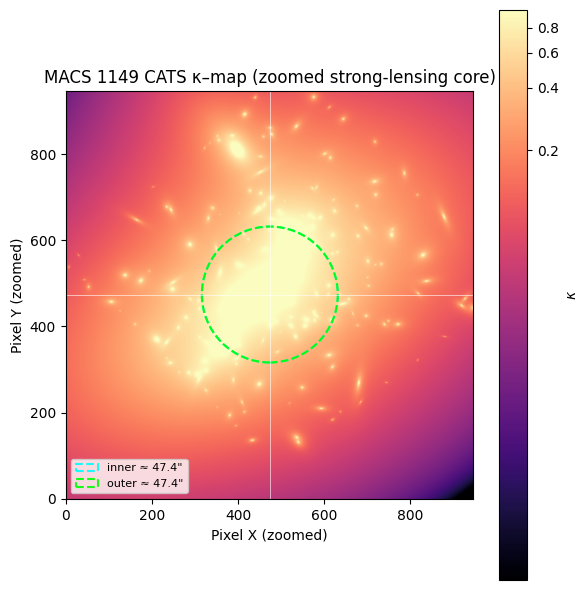

In [23]:
# Cell F: MACS 1149 CATS κ–map with inner/outer shoulders

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

df_cl = results_df[results_df["cluster"] == "MACS1149"]
INNER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].min()
OUTER_SHOULDER_ARCSEC = df_cl["R_sh_arcsec"].max()

tag = "MACS1149_CATS"
opt = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag)
kappa_path = opt["kappa"]

hdul = fits.open(kappa_path)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

ra_str, dec_str = CENTRES["MACS1149"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

inner_shoulder_pix = INNER_SHOULDER_ARCSEC / pix_scale_arcsec
outer_shoulder_pix = OUTER_SHOULDER_ARCSEC / pix_scale_arcsec

zoom_radius_pix = 3.0 * outer_shoulder_pix

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

fig, ax = plt.subplots(figsize=(6, 6))
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)
plt.colorbar(im, ax=ax, label=r"$\kappa$")

ax.set_title("MACS 1149 CATS κ–map (zoomed strong-lensing core)")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")

x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.6, linewidth=0.7)
ax.axvline(x0_zoom, color="white", alpha=0.6, linewidth=0.7)

for r_pix_sh, col, lab in [
    (inner_shoulder_pix, "cyan", f"inner ≈ {INNER_SHOULDER_ARCSEC:.1f}\""),
    (outer_shoulder_pix, "lime", f"outer ≈ {OUTER_SHOULDER_ARCSEC:.1f}\""),
]:
    circ = Circle(
        (x0_zoom, y0_zoom),
        r_pix_sh,
        edgecolor=col,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=lab,
    )
    ax.add_patch(circ)

ax.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


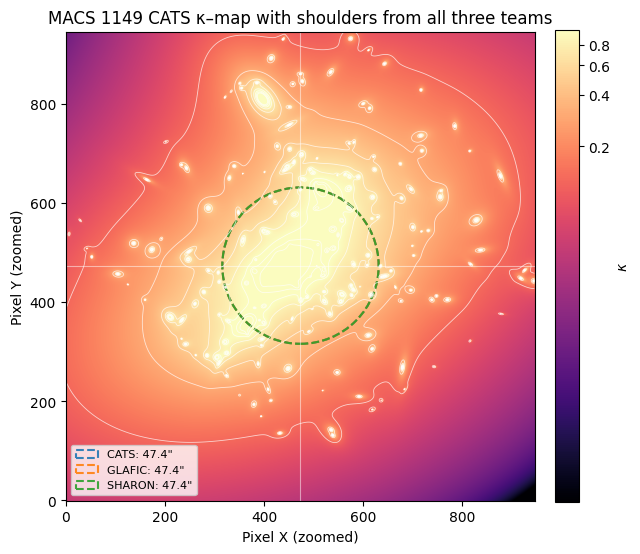

In [22]:
# Cell: MACS 1149 – combined κ–map with κ–contours and all three shoulder circles

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch

# --- 1. Get the three shoulder radii (arcsec) for MACS1149 from results_df ---
df_m1149 = results_df[results_df["cluster"] == "MACS1149"].copy()

# Expect three rows: MACS1149_CATS / GLAFIC / SHARON
radii = {
    row["team"]: row["R_sh_arcsec"]
    for _, row in df_m1149.iterrows()
}

# --- 2. Use the CATS map as the common background / angular grid ---
tag_cats = "MACS1149_CATS"
opt_cats = next(v for v in HFF_OPTIONS.values() if v["TAG"] == tag_cats)
kappa_path_cats = opt_cats["kappa"]

hdul = fits.open(kappa_path_cats)
kappa = hdul[0].data
hdr   = hdul[0].header
hdul.close()

w = WCS(hdr)
pix_scale_arcsec = pixel_scale_arcsec(hdr)

# Centre in pixels from the trusted RA/Dec
ra_str, dec_str = CENTRES["MACS1149"]
coord_c = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg))
x0, y0 = w.all_world2pix([[coord_c.ra.deg, coord_c.dec.deg]], 0)[0]
x0, y0 = float(x0), float(y0)

# --- 3. Choose zoom region (3× largest shoulder) ---
max_R_sh_arcsec = df_m1149["R_sh_arcsec"].max()
zoom_radius_pix = 3.0 * (max_R_sh_arcsec / pix_scale_arcsec)

ny, nx = kappa.shape
x_min = max(0, int(x0 - zoom_radius_pix))
x_max = min(nx, int(x0 + zoom_radius_pix))
y_min = max(0, int(y0 - zoom_radius_pix))
y_max = min(ny, int(y0 + zoom_radius_pix))

kappa_zoom = kappa[y_min:y_max, x_min:x_max]

# --- 4. Plot κ–map + contours + all three circles ---
fig, ax = plt.subplots(figsize=(6.5, 6))

# base image
norm = ImageNormalize(kappa_zoom, interval=ZScaleInterval(), stretch=LogStretch())
im = ax.imshow(kappa_zoom, origin="lower", cmap="magma", norm=norm)

# κ–contours (from the same CATS map)
finite_vals = kappa_zoom[np.isfinite(kappa_zoom)]
vmin = np.percentile(finite_vals, 40)  # suppress very low κ
vmax = np.percentile(finite_vals, 99)
levels = np.linspace(vmin, vmax, 8)
ax.contour(kappa_zoom, levels=levels, colors="white", linewidths=0.6, alpha=0.7)

# crosshair at lens centre in zoomed coordinates
x0_zoom = x0 - x_min
y0_zoom = y0 - y_min
ax.axhline(y0_zoom, color="white", alpha=0.5, linewidth=0.8)
ax.axvline(x0_zoom, color="white", alpha=0.5, linewidth=0.8)

# all three shoulders, mapped into CATS pixel grid
circle_specs = [
    ("MACS1149_CATS",   "C0", "CATS"),
    ("MACS1149_GLAFIC", "C1", "GLAFIC"),
    ("MACS1149_SHARON", "C2", "SHARON"),
]

for team_tag, color, label in circle_specs:
    R_sh_arcsec = radii[team_tag]
    R_sh_pix    = R_sh_arcsec / pix_scale_arcsec
    circ = Circle(
        (x0_zoom, y0_zoom),
        R_sh_pix,
        edgecolor=color,
        facecolor="none",
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=f"{label}: {R_sh_arcsec:.1f}\"",
    )
    ax.add_patch(circ)

ax.set_title("MACS 1149 CATS κ–map with shoulders from all three teams")
ax.set_xlabel("Pixel X (zoomed)")
ax.set_ylabel("Pixel Y (zoomed)")
ax.set_aspect("equal")
ax.legend(loc="lower left", fontsize=8)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$\kappa$")

plt.tight_layout()
plt.show()
